# IMEC2201 Herramientas Computacionales 
## Semana 2: Gráficas y Visualizaciones
### Clase 4: Ajuste de Datos e Incertidumbre

Universidad de los Andes — Abril 6, 2022.

---

## TABLA DE CONTENIDO

### Sección 1: Ajuste de Datos (Regresión OLS) [→](#section1)
- 1.1. Cargar Librerías
- 1.2. Cargar Datos desde Excel
    - 1.2.1. Valores 'Missing'
    - 1.2.2. Filtrar Datos    
- 1.3. Extraer Año, Mes, Día
- 1.4. Reordenar Columnas
- 1.5. Datos Únicos con unique()
- 1.6. Query
- 1.7. Concatenar DataFrames
    - 1.7.1. DataFrame de Voltaje DC
    - 1.7.2. DataFrame de Corriente DC
    - 1.7.3. DataFrame con Irradiancia, Voltaje DC y Corriente DC
- 1.8. Descargar Archivo

### Sección 2: Incertidumbre [→](#section2)
- 2.1. Bases
- 2.2. Gráficas con Datos de DataFrame
___

**¡Importante!** Note que la carpeta **week2** contiene dos archivos: `Project.toml` y `Manifest.toml`. Estos configuran el <font color="#FF5733">*ambiente de trabajo*</font> y facilitan el manejo de <font color="#FF5733">librerías</font>.

Para inicializar el ambiente desde Julia REPL, dentro de la carpeta **week2**, ejecute lo siguiente:

```shell
$ (v1.7) pkg > activate .
$ (week2) pkg> instantiate
```

**Nota:** Para acceder al Pkg REPL, escriba el corchete derecho `]` en el Julia REPL. Note que el REPL cambie de color de verde (Julia REPL) a azul (Pkg REPL). Una vez ejecutado el código `activate .`, el prefijo entre paréntesis indica el ambiente activo: cambia de `v1.7` a `week2`.

O, desde Jupyter Notebook, ejecute:

```julia
$ using Pkg
$ Pkg.activate()
$ Pkg.instantiate()
```

**Nota:** La activación del ambiente <font color="#FF5733">*precompila*</font> las librerías por lo que puede tardar un momento su ejecución completa.

<div class="alert alert-block alert-info">
    
<i class="fa fa-info-circle" aria-hidden="true"></i>
Puede obtener más información en la documentación oficial de la librería [`Pkg.jl`](https://pkgdocs.julialang.org/v1/environments/) y en el documento dando clic [aquí](https://towardsdatascience.com/how-to-setup-project-environments-in-julia-ec8ae73afe9c).
</div>

In [1]:
using Pkg
Pkg.activate(pwd())
Pkg.instantiate()

  Activating project at `~/Documents/GitHub/ua-imec2001-hc-202210/content/week2`


In [2]:
Pkg.status()

      Status `~/Documents/GitHub/ua-imec2001-hc-202210/content/week2/Project.toml`
  [336ed68f] CSV v0.10.4
  [a93c6f00] DataFrames v1.3.2
  [31c24e10] Distributions v0.24.18
  [38e38edf] GLM v1.4.2
  [09f84164] HypothesisTests v0.10.8
  [eff96d63] Measurements v2.7.1
  [91a5bcdd] Plots v1.27.4
  [2913bbd2] StatsBase v0.33.16
  [fdbf4ff8] XLSX v0.7.9
  [37e2e46d] LinearAlgebra
  [10745b16] Statistics


<a id="section1"></a>
# Sección 1: Ajuste de Datos (Regresión OLS)

## 1.1. Cargar Librerías

In [3]:
import CSV
import XLSX
import Plots
import Statistics
import DataFrames
import LinearAlgebra

## 1.2. Mínimos Cuadrados Ordinarios (OLS)

Un ajuste (o <font color="#FF5733">regresión</font>) es una función  $f(x)$ que se aproxima a unos datos sin que necesariamente pase sobre ellos (Vidal, 2017). Ahora bien, un ajuste lineal (o <font color="#FF5733">regresión lineal</font>) busca la determinación de la ecuación de la **recta** que mejor ajusta a una distribución bidimensional (i.e., $x$ y $y$) de datos (Franco, 2016).

$$
Y = aX + b
$$

Siendo $Y$ la variable dependiente, $X$ la variable independiente, $a$ la pendiente y $b$ el intercepto con el eje vertical (i.e., eje $Y$).

El método de **mínimos cuadrados ordinarios** (OLS, por sus siglas en inglés) es un ejercicio de optimización del error cuadrático $e^2$. Es decir, se minimiza la suma de cuadrados de las diferencias (llamados residuos) entre los puntos generados por la función y los correspondientes valores en los datos medidos (Wikipedia, 2021).

$$
\sum_{i=1}^{n} e_i^2 = \sum_{i=1}^{n} \left( y_i - \hat{y}_i \right )^2
$$

<img src='./img/OLS.png' width='350'/>
Figura tomada de [Cuemath - Least Squares](https://www.cuemath.com/data/least-squares/).

In [4]:
df_orig = DataFrames.DataFrame(XLSX.readtable("./data/engines.xlsx", "Data", header=true)...) # ./ es pwd()

df = copy(df_orig)

println("El DataFrame tiene $(size(df)[1]) filas y $(size(df)[2]) columnas.")

first(df, 5)

El DataFrame tiene 39 filas y 10 columnas.


,Index,Engine,Mass (Kg),Number of Cylinders,Strokes per Cycle,Displacement (cm3)
,Any,Any,Any,Any,Any,Any
1,1,Webra Speedy,0.135,1.0,2.0,1.8
2,2,Motori Cipolla,0.15,1.0,2.0,2.5
3,3,Webra Speed 20,0.25,1.0,2.0,3.4
4,4,Webra 40,0.27,1.0,2.0,6.5
5,5,Webra 61 Blackhead,0.43,1.0,2.0,10.0


In [5]:
# Algunas Métricas Estadísticas
DataFrames.describe(df)

,variable,mean,min,median,max
,Symbol,Union…,Any,Union…,Any
1,Index,20.0,1,20.0,39
2,Engine,,Allison V-1710,,Wright GR-2600
3,Mass (Kg),6511.12,0.135,135.0,102300.0
4,Number of Cylinders,7.79487,1.0,6.0,24.0
5,Strokes per Cycle,3.58974,2.0,4.0,4.0
6,Displacement (cm3),7.3883e5,1.8,4700.0,1.19e7
7,Bore (mm),166.844,13.5,102.0,900.0
8,Stroke (mm),213.013,12.5,92.0,1800.0
9,Maximum Brake Horsepower (BHP),2605.67,0.45,140.0,27800.0


### 1.2.1. Gráfica MBHP vs Masa

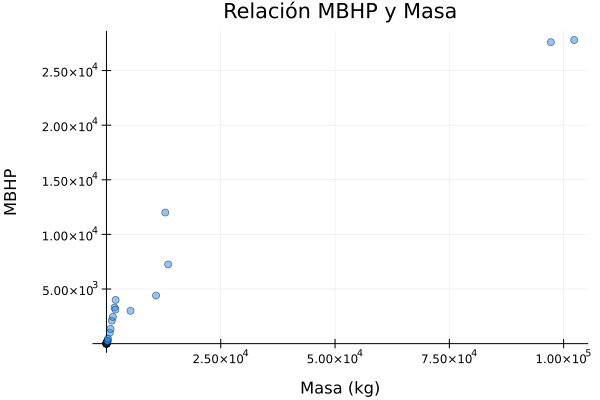

In [6]:
Plots.plot(df."Mass (Kg)",
           df."Maximum Brake Horsepower (BHP)",
           seriestype = :scatter, 
           title="Relación MBHP y Masa", 
           xlabel="Masa (kg)", 
           ylabel="MBHP",
           xrotation=0,
           legend=false,
           m=:circle,
           ms=4,
           mc=:dodgerblue,
           alpha=0.5,
           dpi=500,
           frame=:origin)

Al observar la gráfica anterior, se evidencia poca linealidad entre los datos. Por ende, para conseguir una buena interpretación, se procede a obtener la respectiva relación logarítimica, es decir $log \: \text{MBHP}$ vs. $log \: \text{Masa}$.

En este caso (ambos ejes con valores logarítmicos), tenemos que la pendiente $a$ y el intercepto $b$ es:

$$
Y = aX + log(b) 
$$

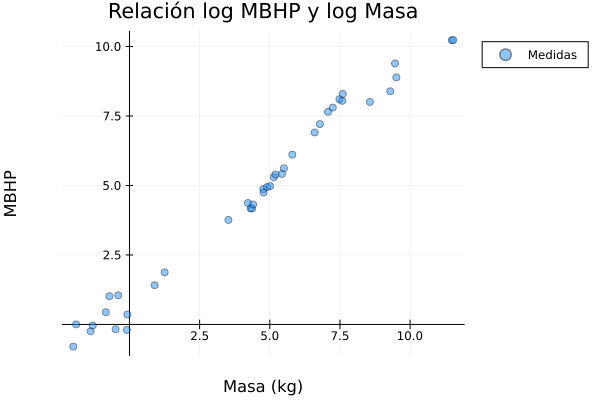

In [7]:
eje_x = log.(df."Mass (Kg)")
eje_y = log.(df."Maximum Brake Horsepower (BHP)")

Plots.plot(eje_x,
           eje_y,
           seriestype = :scatter, 
           title="Relación log MBHP y log Masa", 
           xlabel="Masa (kg)", 
           ylabel="MBHP",
           label="Medidas",
           legend=:outertopright,
           m=:circle,
           ms=4,
           mc=:dodgerblue,
           alpha=0.5,
           dpi=500,
           frame=:origin)

¡Perfecto! Con esta transformación, ahora podemos ver que efectivamente hay una relación lineal entre las variables $\texttt{Masa}$ y $\texttt{MBHP}$.

### 1.2.2. Ajuste Lineal

Una librería que nos permite realizar un ajuste lineal con el método OLS es `GLM` (*Generalized Linear Models*).

La librería `GLM` tiene una función llamada `lm` para los ajustes lineales. Esta tiene los siguientes parámetros de entrada principales:

- `formula`: Usa nombre de columnas del DataFrame (e.g., `names(df) = [:Y,:X1,:X2]`) y una fórmula válida con la sintaxis (e.g., `@formula(Y ~ X1 + X2)`).
- `data`: El DataFrame que contiene los valores.

Más info [aquí](https://juliastats.org/GLM.jl/v0.11/).

Pero... ¿qué es un modelo lineal (o ecuación lineal)?


<div class="alert alert-block alert-success">
> Es una ecuación de primer grado (es decir, involucra una o más variables a la primera potencia) y no contiene productos entre las variables, es decir, la ecuación solo involucra sumas y restas de una variable a la primera potencia.
</div>

In [8]:
df_ols = DataFrames.DataFrame(X = log.(df."Mass (Kg)"),
                              Y = log.(df."Maximum Brake Horsepower (BHP)"))

DataFrames.first(df_ols, 5)

,X,Y
,Float64,Float64
1,-2.00248,-0.798508
2,-1.89712,0.0
3,-1.38629,-0.248461
4,-1.30933,-0.040822
5,-0.84397,0.438255


In [9]:
using GLM

ols = lm(@formula(Y ~ X), df_ols)

ols

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}}}}, Matrix{Float64}}

Y ~ 1 + X

Coefficients:
────────────────────────────────────────────────────────────────────────
                Coef.  Std. Error      t  Pr(>|t|)  Lower 95%  Upper 95%
────────────────────────────────────────────────────────────────────────
(Intercept)  0.910096   0.114241    7.97    <1e-08   0.678621   1.14157
X            0.858983   0.0196934  43.62    <1e-32   0.81908    0.898886
────────────────────────────────────────────────────────────────────────

La columna $\texttt{Coef.}$ nos da la información que necesitamos:
- **Pendiente $a$**: 0.858983
- **Intercepto $b$**: 0.910096

Para visualizar la información, hacemos uso de la función `predict()` que me evalúa el ajuste lineal hecho.

### 1.2.3. Coeficiente de Correlación

El coeficiente de correlación $R^2$ de determina a partir de la función `r2` de la librería `StatsBase`.

In [10]:
import StatsBase

R² = round(StatsBase.r2(ols), digits=2)

R²

0.98

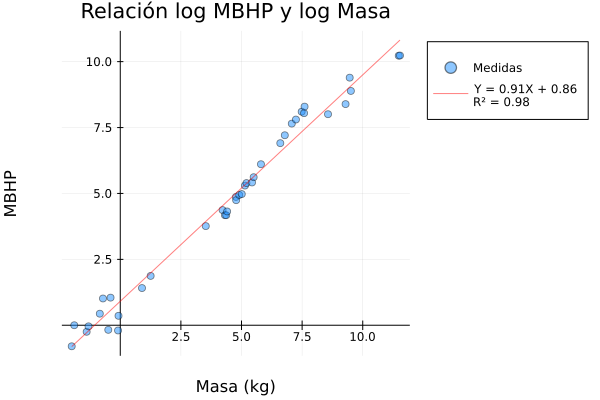

In [11]:
using GLM

a = round(coef(ols)[1], digits=2) # ¿Qué obtenemos con 'coef()'?
b = round(coef(ols)[2], digits=2) # ¿Qué obtenemos con 'coef()'?

Plots.plot!(df_ols."X", predict(ols), color=:red, alpha=0.5, label="Y = $(a)X + $(b)\nR² = $(R²)")

### 1.2.4. Caso Práctico

Queremos obtener el ajuste lineal al correlacionar las variables `Mass (Kg)` y `Displacement (cm3)`. Esta relación también es $log-log$.

El paso a paso que debemos hacer es:
1. Transformar los datos al valor logaritmo.
2. Crear el DataFrame únicamente con las columnas de interés.
3. Usar la librería `GLM` con la sintaxis adecuada (i.e., `GLM.lm(@formula(Y ~ X), df)`).
4. Estimar el valor de $R^2$.
4. Crear la gráfica base.
5. Agregar la línea de tendencia con `predict(ols)`.

## 1.8. Histogramas

Los histogramas permiten visualizar la distribución de un conjunto de datos a partir de la frecuencia de los valores representados en un rango específico. Para este caso, haremos uso de la función `fit` de la librería `StatsBase` para crear nuestro gráfico.

In [16]:
# Estimamos el número de bins con la Regla de Sturge
K = Int(round(1 + 3.322 * log(length(df_ols."Y"))))

# Histograma
using StatsBase

h = fit(Histogram, df_ols."Y", nbins=K)

Histogram{Int64, 1, Tuple{StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}}}
edges:
  -1.0:1.0:11.0
weights: [5, 3, 4, 0, 1, 8, 4, 2, 3, 6, 1, 2]
closed: left
isdensity: false

Para graficar esta información, hacemos uso de la función `bar` de la librería `Plots`.

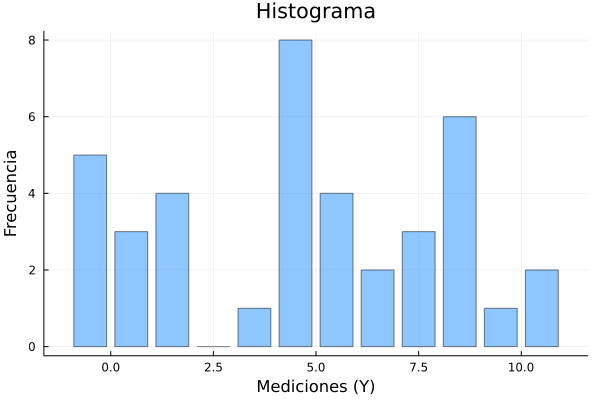

In [17]:
hist = Plots.bar(h.edges, h.weights,
                 xlabel = "Mediciones (Y)",
                 ylabel = "Frecuencia",
                 title = "Histograma",
                 legend = false,
                 color = :dodgerblue,
                 alpha = 0.5)

Podemos agregar líneas de medidas de tendencia central como promedio y desviaciones estándar.

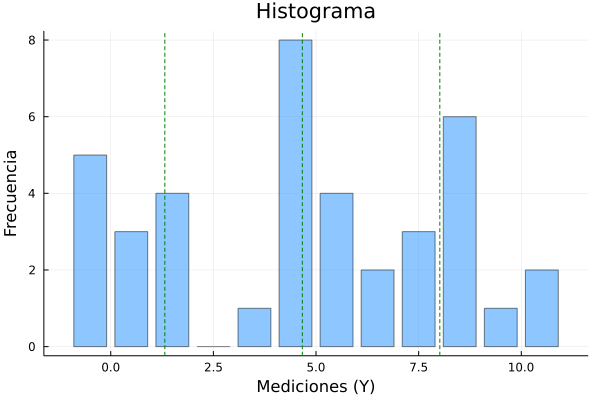

In [18]:
avg = Statistics.mean(df_ols."Y")
desv = Statistics.std(df_ols."Y")

Plots.vline!([avg - desv, avg, avg + desv],
             linestyle=:dash,
             color=:green)

<a id="section2"></a>
# Sección 2: Incertidumbre

## 2.1. Error Aleatorio

Típicamente nos encontramos lo siguiente en una guía de laboratorio:

> **Estimación de Incertidumbre**: Las variables observadas se verán afectadas por la incertidumbre de medición, y aquellas
obtenidas a partir de ecuaciones matemáticas se verán afectadas por el error propagado.
Para estimar las incertidumbres de medición, es importante distinguir entre las fuentes
sistemáticas y aleatorias de error a medida que se realiza el experimento. Para las fuentes
de error aleatorias, **se debe estimar un intervalo de confianza del 95% según la distribución
de probabilidad correspondiente (e.g., t-Student o Normal)**. Debe documentar en el informe
cómo se estimó la incertidumbre de medición y cómo se calculó la propagación de error.

¿Cómo lo podemos hacer en Julia?


Recordemos que, para la distribución Normal (también llamada Gaussiana):

$$
z = \frac{x - \mu}{\sigma_x}
$$

Donde:

$$
\sigma_x = \frac{\sigma}{\sqrt{n}}
$$

Con estos datos, obtenemos el intervalor de confianza:

$$
\mu = x \pm z \sigma_x
$$


Este ejercicio es facilitado con las librerías `Distributions` e `HypothesisTests`.

In [19]:
using Distributions, HypothesisTests

μ = round(Statistics.mean(df_ols."X"), digits=2)
println("Promedio Masa ~ μ = $μ\n")

println(OneSampleTTest(df_ols."X"))

println("\nIntervalo de Confianza (95%): $(confint(OneSampleTTest(df_ols."X")))") # Intervalo de Confianza del 95%

Promedio Masa ~ μ = 4.37

One sample t-test
-----------------
Population details:
    parameter of interest:   Mean
    value under h_0:         0
    point estimate:          4.37293
    95% confidence interval: (3.121, 5.625)

Test summary:
    outcome with 95% confidence: reject h_0
    two-sided p-value:           <1e-07

Details:
    number of observations:   39
    t-statistic:              7.0721047865046005
    degrees of freedom:       38
    empirical standard error: 0.6183354191326009


Intervalo de Confianza (95%): (3.121178263480896, 5.624687491145094)


## 2.2. Barras de Error

Conocido el error de cada dato, `Plots` nos permite agregar las barras de error de manera sencilla a partir del parámetro `yerror`.

In [20]:
error = Array(randn(DataFrames.nrow(df_ols), 1))

df_ols."error" .= error

DataFrames.first(df_ols, 5)

,X,Y,error
,Float64,Float64,Float64
1,-2.00248,-0.798508,1.95405
2,-1.89712,0.0,0.388581
3,-1.38629,-0.248461,-0.658584
4,-1.30933,-0.040822,0.114241
5,-0.84397,0.438255,0.293168


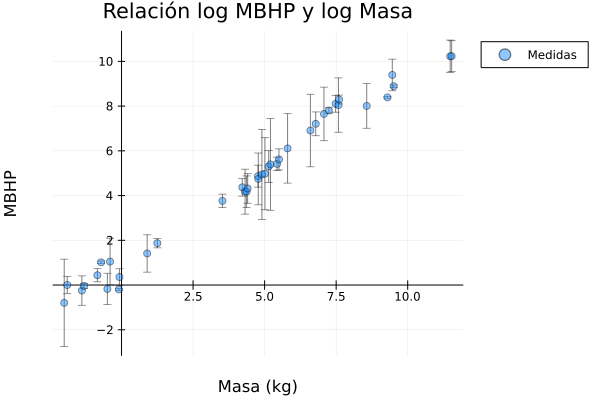

In [21]:
eje_x = log.(df."Mass (Kg)")
eje_y = log.(df."Maximum Brake Horsepower (BHP)")

Plots.plot(eje_x,
           eje_y,
           seriestype = :scatter, 
           title="Relación log MBHP y log Masa", 
           xlabel="Masa (kg)", 
           ylabel="MBHP",
           label="Medidas",
           legend=:outertopright,
           m=:circle,
           ms=4,
           mc=:dodgerblue,
           alpha=0.5,
           dpi=500,
           frame=:origin,
           yerror=df_ols."error")

## 2.3. Librería `Measurements.jl`

La librería `Measurements` también permite agregar barras de error con una sintaxis más clara y ¡es útil para ejercicios de <font color="#FF5733">propagación de error</font> de manera sencilla!. 

Más info [aquí](https://juliaphysics.github.io/Measurements.jl/stable/).

### 2.3.1. Barras de Error

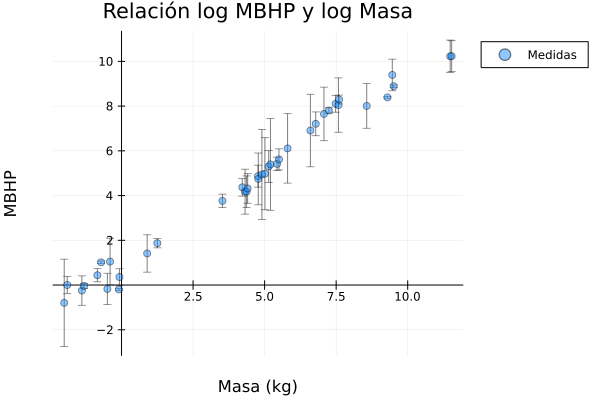

In [22]:
using Measurements

eje_x = df_ols."X"
eje_y = df_ols."Y"
err = df_ols."error"

eff_y = eje_y .± err # Note el término '.±'

Plots.plot(eje_x,
           eff_y,
           seriestype = :scatter, 
           title="Relación log MBHP y log Masa", 
           xlabel="Masa (kg)", 
           ylabel="MBHP",
           label="Medidas",
           legend=:outertopright,
           m=:circle,
           ms=4,
           mc=:dodgerblue,
           alpha=0.5,
           dpi=500,
           frame=:origin,
           yerror=df_ols."error")

### 2.3.2. Propagación de Error

Un péndulo simple se describe a partir de la siguiente ecuación:

$$
T = 2\pi \sqrt{\frac{L}{g}}
$$

Al despejar para la gravedad $g$, obtenemos:

$$
g = \frac{4 \pi^2 L}{T^2}
$$

Ahora, el error propagado para esta ecuación es:

$$
e = \sqrt{ \left( \frac{\partial g}{\partial L} \right)^2 \cdot e_L^2 + \left( \frac{\partial g}{\partial T} \right)^2 \cdot e_T^2}
$$

Luego:

$$
e = \sqrt{ \left( \frac{4 \pi^2}{T^2} \right)^2 \cdot e_L^2 + \left( \frac{-8 \pi^2 L}{T^3} \right)^2 \cdot e_T^2}
$$

In [23]:
# Definimos las variables con su error

L = measurement(0.936, 1e-3); # Forma 1
T = 1.942 ± 4e-3; # Forma 2

In [24]:
# El error, de forma manual, es

termino1 = ((4*pi^2 / (1.942)^2)^2) * (1e-3)^2
termino2 =  ((-8*pi^2*(0.936) / (1.942)^3)^2) * (4e-3)^2

e = √(termino1 + termino2) # √ es igual a la función 'sqrt()'

0.04169781753533666

In [25]:
g = 4pi^2*L / T^2 # Notemos la propagación de error con `Measurements.jl`

9.798 ± 0.042